In [93]:
from tensorflow import keras
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import skopt
from sklearn.model_selection import KFold
import pickle
import matplotlib.pyplot as plt
from skopt.plots import plot_convergence

In [2]:
train = pd.read_csv('./fashion-mnist_train.csv').to_numpy()
test = pd.read_csv('./fashion-mnist_test.csv').to_numpy()

In [3]:
N_CLASSES = 10

In [4]:
x_train = train[:,1:] / 255.0
y_train = train[:,0]
x_test = test[:,1:] / 255.0
y_test = test[:,0]

In [5]:
# Preprocess data for cnn
x_train_cnn = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test_cnn = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [58]:
def build_cnn(n_units=[500], n_hidden_layers=1, learning_rate=1e-3, activation='relu', dropout=0.0, optimizer='adam', n_filters=32, kernel_size=3, pool_size=3):
    model = keras.models.Sequential()
    
    # Add convolutional layer
    model.add(keras.layers.Conv2D(
        filters=n_filters,
        kernel_size=(kernel_size, kernel_size),
        activation=activation,
        name='convolutional_layer'
    ))
    # Add max pooling layer
    model.add(keras.layers.MaxPooling2D(
        pool_size=(pool_size, pool_size),
        name='max_pooling_layer'
    ))
    
    # Add fully connected layer
    for i in range(n_hidden_layers):
        model.add(keras.layers.Dense(units=n_units[i], activation=activation, name=f'hidden_layer_{i}'))
        
    model.add(keras.layers.Flatten())
    
    # Output layer
    model.add(keras.layers.Dense(units=N_CLASSES, activation='softmax', name='output_layer'))
    
    opt = None
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy']
    )
    
    return model

In [59]:
SPACE = [
    skopt.space.Integer(100, 700, name='n_units_one'),
    skopt.space.Integer(50, 500, name='n_units_two'),
    skopt.space.Real(1e-4, .1, prior='log-uniform', name='learning_rate'),
    skopt.space.Categorical(['relu', 'selu', 'tanh'], name='activation'),
    skopt.space.Real(0.0, .5, name='dropout_rate'),
    skopt.space.Categorical(['adam', 'sgd'], name='optimizer'),
    skopt.space.Integer(8, 56, name='n_filters'),
    skopt.space.Integer(1, 5, name='kernel_size'),
    skopt.space.Integer(1, 5, name='pool_size')
]

In [73]:
N_CALLS = 10

In [74]:
model_calls = [ i for i in range(N_CALLS) ]
model_dict = {}

In [75]:
EARLY_STOPPING = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [116]:
@skopt.utils.use_named_args(SPACE)
def objective(**params):
    model_num = model_calls.pop(0)
    
    cv = KFold(5)
    
    path = f'./test_models/cnn_checkpoint_{model_num}.h5'
    checkpoint = keras.callbacks.ModelCheckpoint(
        monitor='val_loss',
        filepath=path,
        verbose=0,
        save_weights_only=True,
        save_best_only=True
    )
    scores = []
    for tr_idx, vl_idx in cv.split(x_train_cnn, y_train):
        x_tr, x_vl = x_train_cnn[tr_idx], x_train_cnn[vl_idx]
        y_tr, y_vl = y_train[tr_idx], y_train[vl_idx]
        
        ts_model = build_cnn(
            n_units=[params['n_units_one'], params['n_units_two']],
            n_hidden_layers=2,
            learning_rate=params['learning_rate'],
            activation=params['activation'],
            dropout=params['dropout_rate'],
            optimizer=params['optimizer'],
            n_filters=params['n_filters'],
            kernel_size=params['kernel_size'],
            pool_size=params['pool_size']
        )
        
        ts_model.fit(x_tr, y_tr, validation_data=(x_vl, y_vl), callbacks=[EARLY_STOPPING, checkpoint], epochs=30, verbose=0)
        
        ts_predictions = ts_model.predict(x_vl)
        class_predictions = [ np.argmax(x) for x in ts_predictions ]
        score = accuracy_score(class_predictions, y_vl)
        scores.append(score)
        
    print(f'--------------------------------------------------')
    print(f'Run #{model_num}')
    print(f'Avg. Val. Acc. :: {np.mean(scores)}')
    
    model_dict[model_num] = {
        'n_units': [params['n_units_one'], params['n_units_two']],
        'learning_rate': params['learning_rate'],
        'activation': params['activation'],
        'dropout': params['dropout_rate'],
        'optimizer': params['optimizer'],
        'n_filters': params['n_filters'],
        'kernel_size': params['kernel_size'],
        'pool_size': params['pool_size'],
        'path': path,
        'avg_score': np.mean(score)
    }
    
    return -np.mean(scores)

In [77]:
# Run optimization
opt_results = skopt.gp_minimize(objective, SPACE, n_calls=N_CALLS, random_state=0)
skopt.dump(opt_results, './tuning/cnn_opt_results.pkl')

938/938 [==============================] - 73s 77ms/step - loss: 292.0711 - accuracy: 0.7154 - val_loss: 620.3167 - val_accuracy: 0.7238
--------------------------------------------------
Run #0
Avg. Val. Acc. :: 0.6879333333333333
938/938 [==============================] - 15s 15ms/step - loss: 0.5511 - accuracy: 0.8048 - val_loss: 0.4653 - val_accuracy: 0.8354
--------------------------------------------------
Run #1
Avg. Val. Acc. :: 0.82745
938/938 [==============================] - 24s 23ms/step - loss: 1.2196 - accuracy: 0.6450 - val_loss: 0.7333 - val_accuracy: 0.7541
--------------------------------------------------
Run #2
Avg. Val. Acc. :: 0.7435499999999999
938/938 [==============================] - 43s 45ms/step - loss: 0.4551 - accuracy: 0.8369 - val_loss: 0.3467 - val_accuracy: 0.8765
--------------------------------------------------
Run #3
Avg. Val. Acc. :: 0.8706
938/938 [==============================] - 9s 9ms/step - loss: 0.5368 - accuracy: 0.8030 - val_loss: 0.3974

In [78]:
opt_loaded = skopt.load('./tuning/cnn_opt_results.pkl')

In [101]:
with open('./tuning/cnn_model_dict.pickle', 'wb') as handle:
    pickle.dump(model_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [102]:
with open('./tuning/cnn_model_dict.pickle', 'rb') as handle:
    model_dict = pickle.load(handle)

In [103]:
# Find best values
avg_scores = [ (i, val['avg_score']) for i, val in model_dict.items() ]
max_val = 0
max_idx = 0
for i in avg_scores:
    if i[1] > max_val:
        max_val = i[1]
        max_idx = i[0]

In [104]:
bp = model_dict[max_idx]

In [105]:
print(bp)

{'n_units': [555, 98], 'learning_rate': 0.002635125223136194, 'activation': 'relu', 'dropout': 0.3684590885644791, 'optimizer': 'adam', 'n_filters': 14, 'kernel_size': 2, 'pool_size': 2, 'avg_score': 0.87, 'path': './test_models/cnn_checkpoint_3.h5'}


In [106]:
ax = plot_convergence(opt_loaded)
plt.savefig('./plots/cnn_one_layer_convergence.png')
plt.clf()

<Figure size 432x288 with 0 Axes>

In [111]:
final_model = build_cnn(
    n_units=[bp['n_units'][0], bp['n_units'][1]],
    n_hidden_layers=2,
    learning_rate=bp['learning_rate'],
    activation=bp['activation'],
    dropout=bp['dropout'],
    optimizer=bp['optimizer'],
    n_filters=bp['n_filters'],
    kernel_size=bp['kernel_size'],
    pool_size=bp['pool_size']
)
final_model.fit(x_train_cnn, y_train, epochs=1)
final_model.load_weights(bp['path'])
final_model.save('./models/cnn_one_layer/')

1875/1875 [==============================] - 60s 32ms/step - loss: 0.3985 - accuracy: 0.8576


2022-04-26 00:43:33.160895: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/cnn_one_layer/assets


In [113]:
final_model_predictions = final_model.predict(x_test_cnn)
class_predictions = [ np.argmax(x) for x in final_model_predictions ]
print(classification_report(y_test, class_predictions))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1000
           1       0.98      0.97      0.97      1000
           2       0.75      0.88      0.81      1000
           3       0.88      0.91      0.89      1000
           4       0.80      0.84      0.82      1000
           5       0.96      0.96      0.96      1000
           6       0.75      0.53      0.62      1000
           7       0.95      0.93      0.94      1000
           8       0.93      0.98      0.96      1000
           9       0.94      0.97      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



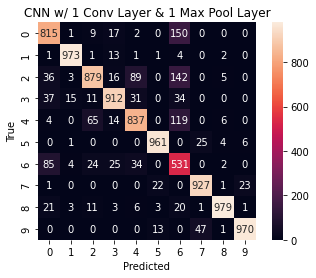

In [115]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, class_predictions)
ax = sns.heatmap(cm.T, square=True, annot=True, fmt='d')
ax.set(title='CNN w/ 1 Conv Layer & 1 Max Pool Layer', xlabel='Predicted', ylabel='True')
plt.savefig('./plots/cnn_one_layer_cm.png')